In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import torchimport numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import os
import PIL
import PIL.Image
import pathlib
from sklearn.model_selection import train_test_split
data_dir = pathlib.Path("/Users/Davran/0_Deep_Learning_Project/Insulator Inspection/Insulator")
data_dir_train = pathlib.Path("/Users/Davran/0_Deep_Learning_Project/Insulator Inspection/Insulator/All/*/*")
#data_dir_test = pathlib.Path("C:/Users/Davran/0_Deep_Learning_Project/Implant Inspection/test/*/*")

In [3]:
keras.backend.set_image_data_format('channels_last')

In [4]:
filenames = tf.io.gfile.glob(str(data_dir_train))
#filenames.extend(tf.io.gfile.glob(str(data_dir_test)))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [5]:
COUNT_CLEAN = len([filename for filename in filenames if "Clean" in filename])
print("Clean images count in training set: " + str(COUNT_CLEAN))

COUNT_POLLUTED = len([filename for filename in filenames if "Polluted" in filename])
print("Polluted images count in training set: " + str(COUNT_POLLUTED))

Clean images count in training set: 71
Polluted images count in training set: 205


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\DSCF0057.JPG'
b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\20200617_124312.jpg'
b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\DSCF0130.JPG'
b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\20200617_123914.jpg'
b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\20200617_124843.jpg'


In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Train images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validation images count: " + str(VAL_IMG_COUNT))

Train images count: 220
Validation images count: 56


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(data_dir) + "/All/*")])
CLASS_NAMES

array(['Clean', 'Polluted'], dtype='<U8')

In [9]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == 'Clean':
        return 0
    else:
        return 1

In [10]:
def decode_img(img):
    # convert the compressed string
    img_X = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    #img_X = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(img_X)
    img_X = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(img_X)
    #img_X = tf.image.convert_image_dtype(img_X, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img_X, IMAGE_SIZE)

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = (150, 150)
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
X_train = []
y_train = []

for image, label in train_ds:
    X_train.append(image)
    y_train.append(label)    
X_train = np.array(X_train, dtype = 'float32')
y_train = np.array(y_train, dtype = 'int8')

shuffled_idx = np.random.permutation(TRAIN_IMG_COUNT)
X_train[:] = X_train[shuffled_idx]
y_train[:] = y_train[shuffled_idx]
print(X_train.shape)
print(y_train.shape)

(220, 150, 150, 3)
(220,)


In [14]:
X_val = []
y_val = []

for image, label in val_ds:
    X_val.append(image)
    y_val.append(label)    
X_val = np.array(X_val, dtype = 'float32')
y_val = np.array(y_val, dtype = 'int8')

shuffled_idx = np.random.permutation(VAL_IMG_COUNT)
X_val[:] = X_val[shuffled_idx]
y_val[:] = y_val[shuffled_idx]
print(X_val.shape)
print(y_val.shape)

(56, 150, 150, 3)
(56,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


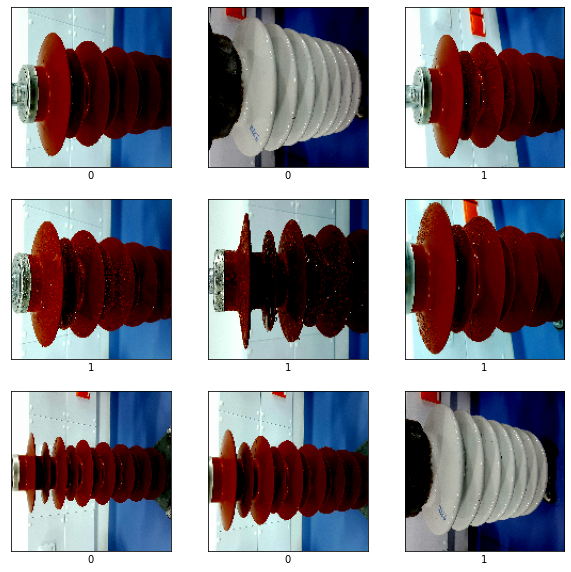

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap = plt.cm.binary)
    plt.xlabel(y_train[i])
    
# The figure below shows the downsampled images of insulators with the labels below.

In [16]:
IMG_SHAPE = IMAGE_SIZE + (3, ) 
IMG_SHAPE

(150, 150, 3)

In [17]:
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [19]:
#image_batch, label_batch = next(iter(X_train))
feature_batch = base_model(X_train)
print(feature_batch.shape)

(220, 4, 4, 512)


In [20]:
X_train.shape

(220, 150, 150, 3)

In [21]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(220, 1)


In [24]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_______________________________________________

In [27]:
len(model.trainable_variables)

2

In [28]:
type(X_val)

numpy.ndarray

In [29]:
tf.config.run_functions_eagerly(True)

In [30]:
initial_epochs = 150

loss0, accuracy0 = model.evaluate(X_val, y_val)

C:\Users\Davran\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 2s 837ms/step - loss: 0.6999 - accuracy: 0.4107


In [31]:
history = model.fit(X_train,
                    y_train,
                    epochs=initial_epochs,
                    validation_data = (X_val, y_val)
                    )

Epoch 1/150
7/7 [==============================] - 7s 577ms/step - loss: 0.6377 - accuracy: 0.4727 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 2/150
7/7 [==============================] - 1s 184ms/step - loss: 0.5986 - accuracy: 0.5318 - val_loss: 0.7008 - val_accuracy: 0.5179
Epoch 3/150
7/7 [==============================] - 1s 183ms/step - loss: 0.6028 - accuracy: 0.5273 - val_loss: 0.7017 - val_accuracy: 0.5714
Epoch 4/150
7/7 [==============================] - 1s 183ms/step - loss: 0.6006 - accuracy: 0.6318 - val_loss: 0.7028 - val_accuracy: 0.5893
Epoch 5/150
7/7 [==============================] - 1s 184ms/step - loss: 0.5901 - accuracy: 0.6045 - val_loss: 0.7044 - val_accuracy: 0.5179
Epoch 6/150
7/7 [==============================] - 1s 185ms/step - loss: 0.5892 - accuracy: 0.6227 - val_loss: 0.7061 - val_accuracy: 0.5357
Epoch 7/150
7/7 [==============================] - 1s 184ms/step - loss: 0.5783 - accuracy: 0.6455 - val_loss: 0.7075 - val_accuracy: 0.5536
Epoch 8/150
7

Epoch 59/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4951 - accuracy: 0.7455 - val_loss: 0.6567 - val_accuracy: 0.6071
Epoch 60/150
7/7 [==============================] - 1s 185ms/step - loss: 0.4739 - accuracy: 0.7818 - val_loss: 0.6547 - val_accuracy: 0.6071
Epoch 61/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4850 - accuracy: 0.7636 - val_loss: 0.6538 - val_accuracy: 0.6071
Epoch 62/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4899 - accuracy: 0.7455 - val_loss: 0.6520 - val_accuracy: 0.6071
Epoch 63/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4864 - accuracy: 0.7636 - val_loss: 0.6506 - val_accuracy: 0.6071
Epoch 64/150
7/7 [==============================] - 1s 185ms/step - loss: 0.4737 - accuracy: 0.7636 - val_loss: 0.6498 - val_accuracy: 0.6071
Epoch 65/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4698 - accuracy: 0.7591 - val_loss: 0.6487 - val_accuracy: 0.6071
Epoch 

7/7 [==============================] - 1s 187ms/step - loss: 0.4298 - accuracy: 0.7909 - val_loss: 0.6018 - val_accuracy: 0.7321
Epoch 117/150
7/7 [==============================] - 1s 187ms/step - loss: 0.4048 - accuracy: 0.8455 - val_loss: 0.5998 - val_accuracy: 0.7321
Epoch 118/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4349 - accuracy: 0.7909 - val_loss: 0.5996 - val_accuracy: 0.7321
Epoch 119/150
7/7 [==============================] - 1s 187ms/step - loss: 0.4180 - accuracy: 0.8364 - val_loss: 0.5994 - val_accuracy: 0.7321
Epoch 120/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4218 - accuracy: 0.8182 - val_loss: 0.5990 - val_accuracy: 0.7321
Epoch 121/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4279 - accuracy: 0.7955 - val_loss: 0.5991 - val_accuracy: 0.7321
Epoch 122/150
7/7 [==============================] - 1s 186ms/step - loss: 0.4171 - accuracy: 0.8000 - val_loss: 0.5979 - val_accuracy: 0.7321
Epoch 123/150

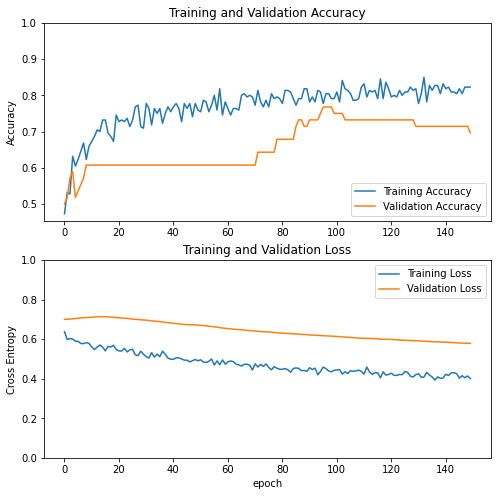

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()